# Option Implied Volatility using Deep Learning Model
by Chee-Foong
on 8 Jul 2020

---
## Summary
These data and assumptions are not easily available and are usually reflected in the prices traded in the market.

Implied volatility is traditionally calculated by taking the market price of the option, entering it into the Black-Scholes formula, and back-solving for the value of the volatility. But there are various approaches to calculating implied volatility. One simple approach is to use an iterative search, or trial and error, to find the value of implied volatility.  However, an iterative search process is time-consuming.  This is especially so if when there are so many options at different strike prices and maturity dates to calculate.  

This analysis attempts to build a model using Artifical Neural Networks that will calculate the implied volatility of options based on their last price and other standard option attributes.  Once built, the model can be used to estimate the implied volatility of options quickly and be used to identify and create trading opportunities on mispricing options.

Using Tensorflow and Keras libraries to train a deep learning regression model on the following features:
- Strike Price of an option
- Current Price of the underlying stock
- Time to expiration
- Option Type - Call / Put
- Option Last Price

and targeting the implied volatilty.  For model training purpose, the implied volatility is calculated using iterative search on the Black-Scholes formula.

As the model is traded on observable prices and option attributes, I assume all other analytics and assumptions are reflected in the option prices.  The model will be trained and adjust its model weights accordingly.

It is observed that the final model performs reasonably well on unseen data.  The notebook here walk you through the whole model building and validation process.

---
## Loading the libraries

In [1]:
import time

import numpy as np   # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

## Changing the default settings
pd.options.display.max_columns = 50
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':60})
plt.style.use('fivethirtyeight')

import re
import random

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

In [2]:
import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/.DS_Store
../data/out_of_sample.csv
../data/train_valid_test.csv


---
## Helper Functions

1. **combineTrainTest** - For data transformation and feature engineering with needs to be applied to both Train and Test set consistently.
2. **splitTrainTest** - For splitting the combined dataset back to train and test after data transformation and feature engineering.
3. **plot_importances** - For showing the feature importances as determined by the model.
4. **plot_scatter** - Scatter plot of 2 variables in a table
5. **plot_pairs** - Pair plot of multi variables in a table
6. **seedeverything** - Setting the seed for reproducible results

In [3]:
def combineTrainTest(train, test, features):
    train = train[features]
    test = test[features]
    out = pd.concat([train, test])
    return out

def splitTrainTest(traintest, train, test, target):
    train = traintest.loc[train.index].join(train[target])
    test = traintest.loc[test.index]
    return train, test

def plot_importances(model, columns, top=20):
    importances = pd.Series(data=model.feature_importances_, index=columns).sort_values()

    plt.figure(figsize=(10,6))
    importances[-top:].sort_values().plot(kind='barh', color='lightgreen')
    plt.title('Features Importances')
    plt.show()
    
def plot_scatter_byGrp(data, xlabel, ylabel, group, xlocator=5, ylocator=5, alpha=0.1):    
    fig, ax = plt.subplots(figsize=(12, 6))   
    sns.scatterplot(ax=ax, x=xlabel, y=ylabel, hue=group, alpha=alpha, data=data)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    ax.xaxis.set_major_locator(ticker.MultipleLocator(xlocator))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(ylocator))
    plt.show()    
    
def plot_scatter(data, xlabel, ylabel):
    fig, ax = plt.subplots()
    ax.scatter(x = data[xlabel], y = data[ylabel])
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.show()    
    
def plot_check(data, xlabel, ylabel):
    fig, ax = plt.subplots()
#     ax.scatter(x = data[xlabel], y = data[ylabel])
    sns.scatterplot(ax=ax, x = xlabel, y = ylabel, data = data)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.show()    

def plot_pairs(data, columns):
    #scatterplot
    sns.set()
    sns.pairplot(data[columns], size = 2.5)
    plt.show()
    
def seedeverything(seed = 3567): 
    random.seed(seed) 
    np.random.seed(seed) 
    os.environ['PYTHONHASHSEED'] = str(seed) 
    tf.random.set_seed(seed)    

### Implied volatilty calculation based on Newton's method

Reference [here](https://aaronschlegel.me/implied-volatility-functions-python.html)

In [4]:
import scipy.stats as si

def newton_vol_call_div(S, K, T, C, r, q, sigma):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    fx = S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0) - C

    vega = (1 / np.sqrt(2 * np.pi)) * S * np.exp(-q * T) * np.sqrt(T) * np.exp((-si.norm.cdf(d1, 0.0, 1.0) ** 2) * 0.5)

    tolerance = 0.000001
    x0 = sigma
    xnew  = x0
    xold = x0 - 1

    while abs(xnew - xold) > tolerance:

        xold = xnew
        xnew = (xnew - fx - C) / vega

        return abs(xnew)
    
    
def newton_vol_put_div(S, K, T, P, r, q, sigma):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    fx = K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) -  P
    
    vega = (1 / np.sqrt(2 * np.pi)) * S * np.exp(-q * T) * np.sqrt(T) * np.exp((-si.norm.cdf(d1, 0.0, 1.0) ** 2) * 0.5)
    
    tolerance = 0.000001
    x0 = sigma
    xnew  = x0
    xold = x0 - 1
        
    while abs(xnew - xold) > tolerance:
    
        xold = xnew
        xnew = (xnew - fx - P) / vega
        
        return abs(xnew)
    
    
def calcImpliedVol(data, intrate=0.001, div=0):
    out = 0
    
    S, K, T, Opt, r, q, sigma = data['underlyingPrice'], data['strikePrice'], data['daysToExpiration'], \
                            data['last'], intrate, div, data['underlyingVol']
        
    if data['putCall'] == 'CALL':
        out = newton_vol_call_div(S, K, T, Opt, r, q, sigma) * 100
    else:
        out = newton_vol_put_div(S, K, T, Opt, r, q, sigma) * 100

    return out
    

In [5]:
SEED = 3567
seedeverything(SEED)

---
## Loading the Dataset

Option data are extracted using the [ThinkOrSwim api](https://developer.tdameritrade.com/apis).  These are plain vanilla CALL and PUT equity options of all the securities in the Dow Jones Industrial Average which have 30 underlying securities.  Each option type will have 20 strikes count at 2.5 intervals covering all Out-Of-The-Money, In-The_Money options.

The dataset contains 15 snapshots of option statistics at 10 minutes intervals during US Market open.  In total, there are 136692 observations.

In [6]:
DATA_FOLDER = '../data/'
traintest = pd.read_csv(DATA_FOLDER + 'train_valid_test.csv')
# test = pd.read_csv(DATA_FOLDER + 'test.csv', index_col='Id')
# submission = pd.read_csv(DATA_FOLDER + 'sample_submission.csv')

In [7]:
print(traintest.shape)

(136692, 21)


In [8]:
traintest.columns

Index(['datetimestamp', 'underlyingSymbol', 'underlyingPrice', 'underlyingVol',
       'putCall', 'strikePrice', 'expirationType', 'inTheMoney',
       'lastTradingDay', 'expirationDate', 'daysToExpiration', 'openInterest',
       'theoreticalVolatility', 'volatility', 'theoreticalOptionValue',
       'closePrice', 'last', 'mark', 'bid', 'ask', 'underlyingDiv'],
      dtype='object')

In [9]:
print(pd.to_datetime(traintest.datetimestamp).dt.tz_localize('UTC').dt.tz_convert('US/Eastern').min())
print(pd.to_datetime(traintest.datetimestamp).dt.tz_localize('UTC').dt.tz_convert('US/Eastern').max())

2020-07-08 13:03:55.783816-04:00
2020-07-08 16:10:44.076306-04:00


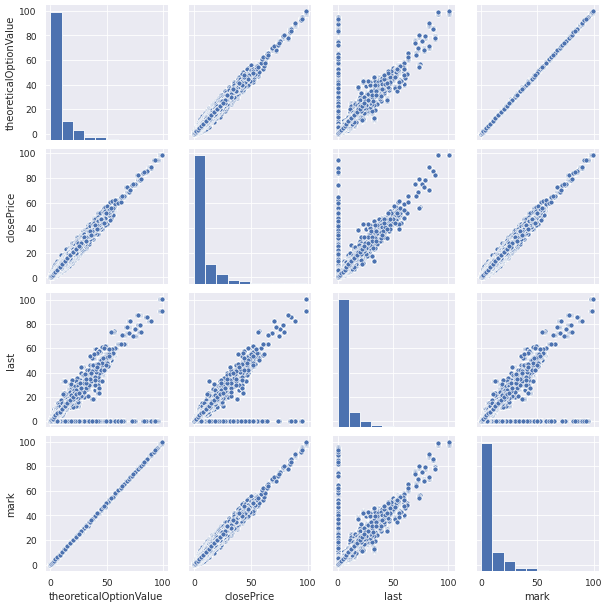

In [10]:
plot_pairs(traintest, ['theoreticalOptionValue','closePrice','last', 'mark'])

To use **last** price to calculate implied volatility

There are 3 volatility measures.  Namely, underlyingVol, theoreticalVolatility and volatility.  **underlyingVol** is the annualised volatility of the underlying stock based on daily returns.  This measure is calculated separately using price data and is not provided by TOS.  **theoreticalVolatility** and **volatility** are measures provided by TOS but there are no documentation on how these numbers are derived nor calculated.  

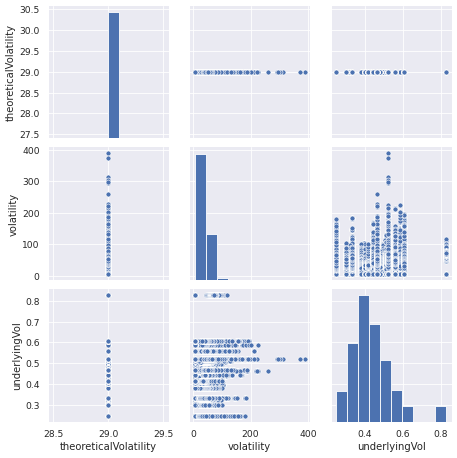

In [11]:
plot_pairs(traintest, ['theoreticalVolatility','volatility','underlyingVol'])

**theoreticalOptionValue** is not meaningful.  Looks like is defaulted to 29% for all options.  **underlyingVol** is the same for all options with the same underlying even though they have diferent strike price and maturity dates. There is no relationship between **volatility** and **underlyingVol**.

I decided that we should calculate the **impliedVolatility** based on Black-Scholes formula using iterative search.  This will be the target of the Deep Learning model.

In [12]:
traintest['underlyingDiv'] = traintest['underlyingDiv']/100

In [13]:
%time traintest['impliedVolatility'] = traintest.apply(lambda x: calcImpliedVol(x), axis=1)

CPU times: user 44.8 s, sys: 450 ms, total: 45.2 s
Wall time: 45.1 s


In [14]:
# plot_scatter_byGrp(traintest, 'impliedVolatility', 'underlyingVol', 'putCall', 20, 20, 0.8)

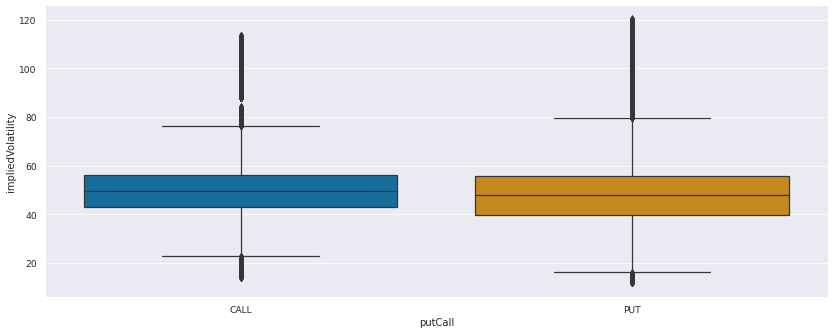

In [15]:
sns.boxplot(y='impliedVolatility', x='putCall', 
                 data=traintest, 
                 palette="colorblind")
plt.show()

#### Defining the Targets and Selected Features

**Target** - Calculated Implied Volatility  
**Features** - Underlying Symbol, Underlying Last Price, Option Type, Option Strike Price, Days to Expiration

Excluded **underlyingVol** as a feature

In [16]:
target = ['impliedVolatility'] # 'theoreticalOptionValue','last','closePrice'
features = ['underlyingSymbol','underlyingPrice', 'putCall', 'last',
            'strikePrice','daysToExpiration'] #,'openInterest','inTheMoney', 'underlyingVol', 

In [17]:
# Note dates are in UTC Datetime

# traintest['datetimestamp'] = pd.to_datetime(traintest['datetimestamp']) 
# traintest['expirationDate'] = pd.to_datetime(traintest['expirationDate'])
# traintest['lastTradingDay'] = pd.to_datetime(traintest['lastTradingDay'])

Selecting only the required columns

In [18]:
traintest = traintest[features + target]

To only use observations with a position option last price.  Options with zero or negative last prices are illogical.

In [19]:
traintest = traintest[traintest[target[0]] > 0]

---
## Data Exploratory

#### Identifying the data type:  
**Numerical**: underlyingPrice, strikePrice, daysToExpiration, impliedVolatility, last
**Categorical**: underlyingSymbol, putCall

In [20]:
traintest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136692 entries, 0 to 136691
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   underlyingSymbol   136692 non-null  object 
 1   underlyingPrice    136692 non-null  float64
 2   putCall            136692 non-null  object 
 3   last               136692 non-null  float64
 4   strikePrice        136692 non-null  float64
 5   daysToExpiration   136692 non-null  int64  
 6   impliedVolatility  136692 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 8.3+ MB


Any columns with missing data?

In [21]:
traintest.isnull().any().any()

False

In [22]:
traintest.describe(include=np.number)

,underlyingPrice,last,strikePrice,daysToExpiration,impliedVolatility
count,136692.000000,136692.000000,136692.000000,136692.000000,136692.000000
mean,126.816027,5.838353,127.102961,28.132985,49.499092
std,82.723496,9.174104,84.458166,20.111044,12.019989
min,33.675000,0.000000,15.000000,2.000000,11.548711
25%,58.075000,0.450000,57.500000,9.000000,41.420876
50%,114.525000,2.490000,110.000000,23.000000,48.873613
75%,179.925000,6.700000,175.000000,37.000000,55.954823
max,381.145000,101.000000,430.000000,72.000000,120.504496


In [23]:
traintest.describe(include=[np.object])

,underlyingSymbol,putCall
count,136692,136692
unique,30,2
top,AXP,PUT
freq,4800,68346


Splitting the features and target into X and y variables respectively

In [24]:
X = traintest[features]
y = traintest[target]

## Data Transformation
Transformation of features for tensorflow.
1. Numeric features - Normalised
2. Numeric target - Normalised
3. Binary features - Label Encoded
4. Multilabel features - One Hot Encoded

All encoders and scalers are saved so that similar transformation can be applied to test data (unseen data) for model predictions.

### More libraries

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

### More helper functions

1. **appendbyCol** - Append two dataframes with the same number of rows by columns.
2. **processOHE** - One Hot Encoding train-valid-test datasets by columns.  Return train-fitted OHE.
3. **applyOHE** - One Hot Encoding similar dataset by columns with train-fitted OHE.
4. **processLE** - Label Encoding train-valid-test datasets by columns.  Return train-fitted Label Encoder.
5. **applyLE** - Label Encoding similar dataset by columns with train-fitted Label Encoder.
6. **processStdScaler** - Normalising train-valid-test datasets by columns.  Return train-fitted Scaler.
7. **applyStdScaler** - Normalising similar dataset by columns with train-fitted Scaler.

In [26]:
def appendbyCol(df1, df2):
    df = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)], axis=1)
    return df

def processOHE(train, test, valid, column, drop=True):
    
    train_ohe = train.copy()
    test_ohe = test.copy()
    valid_ohe = valid.copy()
    
    ohe = OneHotEncoder(sparse=False, handle_unknown='error')
        
    ohe.fit(train[[column]])
    train_ohe = applyOHE(train_ohe, column, ohe, drop)
    test_ohe = applyOHE(test_ohe, column, ohe, drop)
    valid_ohe = applyOHE(valid_ohe, column, ohe, drop)
        
    return train_ohe, test_ohe, valid_ohe, ohe

def applyOHE(data, column, ohe_fitted, drop=True):
    transformed = ohe_fitted.transform(data[[column]])
    columns = list(ohe_fitted.categories_[0])
    out = pd.DataFrame(transformed, columns=columns)
    data = appendbyCol(data, out)
    if drop: 
        data.drop(column, axis=1, inplace=True)
    return data

def processLE(train, test, valid, column):
    
    train_le = train.copy()
    test_le = test.copy()
    valid_le = valid.copy()
    
    le = LabelEncoder()
        
    le.fit(train[[column]])
    train_le[column] = le.transform(train[[column]])
    test_le[column] = le.transform(test[[column]])
    valid_le[column] = le.transform(valid[[column]])
        
    return train_le, test_le, valid_le, le

def applyLE(data, column, le_fitted):
    data[column] = le_fitted.transform(data[[column]])
    return data

def processStdScaler(train, test, valid, columns):
    
    train_scaled = train.copy()
    test_scaled = test.copy()
    valid_scaled = valid.copy()

    scaler = StandardScaler()
    scaler.fit(train[columns])
    train_scaled[columns] = scaler.transform(train[columns])
    test_scaled[columns] = scaler.transform(test[columns])
    valid_scaled[columns] = scaler.transform(valid[columns])

    return train_scaled, test_scaled, valid_scaled, scaler

def applyStdScaler(data, columns, scaler_fitted):
    data_scaled = data.copy()
    data_scaled[columns] = scaler_fitted.transform(data[columns])
    return data_scaled

Creating the datasets:

1. X_train, y_train
2. X_valid, y_valid
3. X_test, y_test

*X_ prefix as features, y_ prefix as target*

In [27]:
## Not using pandas get dummies
# X = pd.get_dummies(X, drop_first=True)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=SEED)
X_test, X_valid, y_test, y_valid = train_test_split(X_valid, y_valid, test_size=0.5, random_state=SEED)

### Numerical Features

Normalising the numerical features

In [28]:
tonormalise = ['underlyingPrice','strikePrice', 'last',
               'daysToExpiration'] # ,'openInterest','optionPayoff','underlyingVol'

In [29]:
X_train, _, X_valid, trainScaler = processStdScaler(X_train, X_test, X_valid, tonormalise)

### Catergorical Features

Transforming for train and validation dataset.

In [30]:
X_train, _, X_valid, putCall_LE = processLE(X_train, X_test, X_valid, 'putCall')
X_train, _, X_valid, symbol_OHE = processOHE(X_train, X_test, X_valid, 'underlyingSymbol')

### Similar Transformation for Test Dataset
Transform for test dataset.  Note that I could have performed the transformation of the test dataset togther with the train and validation dataset but was excluded on purpose so that is more realistic in a production environment.

In [31]:
X_test = applyStdScaler(X_test, tonormalise, trainScaler)
X_test = applyOHE(X_test, 'underlyingSymbol', symbol_OHE)
X_test = applyLE(X_test, 'putCall', putCall_LE)

### Normalising the Target variable
Only applicable for train and validation target variable.  Target variable for the test dataset will be compared with the predicted values after reversed transformation.

In [32]:
targetScaler = StandardScaler()
targetScaler.fit(y_train)
y_train[target] = targetScaler.transform(y_train)
y_valid[target] = targetScaler.transform(y_valid)

Cleaning up and ensure the shape of the dataset are per expectation

In [33]:
y_train.reset_index(drop=True, inplace=True)
y_valid.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [34]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(123022, 35)
(123022, 1)
(6835, 35)
(6835, 1)
(6835, 35)
(6835, 1)


## Training

In [35]:
# !pip install tensorflow
# !pip install -q git+https://github.com/tensorflow/docs

### Final Features used for model training
1. Underlying Stock Price - Stock price at the point of option valuation
2. Option Last Price - Last option traded price
3. Option Strike Price - Option attribute
4. Option Days to Expiry - Number of days between valuation date and option expiry date
5. Option Type - Option attribute (Call or Put)

#### Excluded on purpose
6. Option Payoff - Option payoff at valuation date if valuation date = expiry date
7. Moneyness - Whether the option is currently in the money (known by comparing underlying stock price and option strike price

In [36]:
INPUTS = len(X_train.columns)
TRAINING_OBSERVATIONS = X_train.shape[0]
print('Number of inputs to neural network: {}'.format(INPUTS))
print('Number of training observations: {}'.format(TRAINING_OBSERVATIONS))

X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

Number of inputs to neural network: 35
Number of training observations: 123022


### Model Building Considerations:
1. Problem Identification 
    - Binary, Multiclass, Multilabel, Regression
2. Number of Dense layers
    - What is the Activation function
    - Number of Nodes in each layer
    - Any kernel_initializer?
3. Optimization function
    - learning rate and many other parameters (to explore)
4. Loss function
5. Metrics
6. Fitting Parameters
    - Optimal Batch Size
    - Training and Validation Dataset
    - Number of EPOCHS
    - EarlyStopping - patience number
    - ModelCheckpoint

Additional Considerations:
1. Normalisation layers
2. Dropout layers

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_model(nodes=(16,32,16), activation='relu', learning_rate=0.002, input_dropout=0.05):
    model = Sequential()

    model.add(Dense(nodes[0], input_shape=(INPUTS,), activation='relu', kernel_initializer='normal'))
    model.add(tf.keras.layers.Dropout(input_dropout))
    
    for node in nodes[1:]:
        model.add(Dense(node, activation='relu', kernel_initializer='normal'))

    # model.add(tf.keras.layers.BatchNormalization())

    model.add(Dense(1))

    # opt = tf.keras.optimizers.RMSprop(learning_rate)
    # opt = 'RMSprop'
    opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)

    model.compile(optimizer=opt, loss='mse', metrics=['mae', 'mse'])

    return model

### Hyperparameters Search

Balancing between the complexity and accuracy of the deep learning model, my objective is always to build a simple model that trains efficiently without compromising too much on accuracy.  Hence, I start off by using a 3-layer model, limiting myself to 256, 512 and 1024 nodes in each layer.  Such permutations will generate 27 different models for model fitting.  Combined with other parameters:
1. Type of activation function in the layers - limiting to one type per model
2. Batch Size
3. Number of Epochs
4. Learning Rate
5. Dropout rate for Dropout Layer (if necessary)

I have tried many different permutations of parameters.  I am using the parameters that are most optimal so that the whole search process will not be too long.

Grid Search will search for the optimal parameters for each model by looking for the one with the lowest MSE, 3-fold cross valiation on only the train dataset.  With the settings, the whole process took around **12** hours to complete on my computer.

In [38]:
import itertools

layer1 = [256,512,1024]
layer2 = [256,512,1024]
layer3 = [256,512,1024]
layers = [layer1, layer2, layer3]

NODES_LIST = list(itertools.product(*layers))
ACTIVATION_LIST = ['relu'] ## 'relu', 'sigmoid', 'tanh', 'leaky_relu'
BATCHSIZE_LIST = [256]
EPOCHS_LIST = [200]
LEARNINGRATE_LIST = [0.0005]
INPUTDROPOUT_LIST = [0]

# Define the parameters to try out
params = {'nodes': NODES_LIST, 
          'activation': ACTIVATION_LIST, 
          'batch_size': BATCHSIZE_LIST, 
          'epochs': EPOCHS_LIST, 
          'input_dropout': INPUTDROPOUT_LIST, 
          'learning_rate': LEARNINGRATE_LIST}

print(params)

{'nodes': [(256, 256, 256), (256, 256, 512), (256, 256, 1024), (256, 512, 256), (256, 512, 512), (256, 512, 1024), (256, 1024, 256), (256, 1024, 512), (256, 1024, 1024), (512, 256, 256), (512, 256, 512), (512, 256, 1024), (512, 512, 256), (512, 512, 512), (512, 512, 1024), (512, 1024, 256), (512, 1024, 512), (512, 1024, 1024), (1024, 256, 256), (1024, 256, 512), (1024, 256, 1024), (1024, 512, 256), (1024, 512, 512), (1024, 512, 1024), (1024, 1024, 256), (1024, 1024, 512), (1024, 1024, 1024)], 'activation': ['relu'], 'batch_size': [256], 'epochs': [200], 'input_dropout': [0], 'learning_rate': [0.0005]}


In [39]:
# Import KerasRegressor from keras wrappers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Create a KerasRegressor
grid_buildmodel = KerasRegressor(build_fn = build_model)

grid_search = GridSearchCV(grid_buildmodel, param_grid = params, cv = 3, verbose=0, return_train_score=True)

Comment ***%%capture*** below to show output 
- gridsearchlog.show() to show
- capture [--no-stderr] [--no-stdout] [--no-display] [output]

In [40]:
%%capture --no-display gridsearchlog
%time grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f435ce97fd0>,
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['relu'], 'batch_size': [256],
                         'epochs': [200], 'input_dropout': [0],
                         'learning_rate': [0.0005],
                         'nodes': [(256, 256, 256), (256, 256, 512),
                                   (256, 256, 1024), (256, 512, 256),
                                   (256, 512, 512)...
                                   (256, 1024, 1024), (512, 256, 256),
                                   (512, 256, 512), (512, 256, 1024),
                                   (512, 512, 256), (512, 512, 512),
                                   (512, 512, 1024), (512, 1024, 256),
                                   (512, 1024, 512), (512, 1024, 1024),
                                   (1024, 256, 256), (1024, 256, 512),
     

In [42]:
best_parameters = grid_search.best_params_
print('The optimal parameters: {}'.format(best_parameters))

The optimal parameters: {'activation': 'relu', 'batch_size': 256, 'epochs': 200, 'input_dropout': 0, 'learning_rate': 0.0005, 'nodes': (1024, 1024, 512)}


## Final Model
### Helper Function

1. **plot_results** - For plotting train and validation results across all epochs

In [46]:
def plot_results(data, val_data, title='Results', N=3):
    limit = np.mean(val_data)*N
    plt.figure()
    plt.plot(data)
    plt.plot(val_data)
    plt.ylim([0, limit])
    plt.title(title)
    plt.ylabel(title)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

### Building the Best Model
Trying out the model with the best parameters

In [43]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow_docs.modeling import EpochDots

NODES = ((1024, 1024, 512))
LR = 0.0005
ACTIVATION = 'relu'
EPOCHS = 200
BATCH_SIZE = 256
INPUT_DROPOUT = 0
PATIENCE = int(EPOCHS * 0.1)    ## To reduce training time.  
                                ## Early stopping when there is no further improvement after 10% of Epoch

# Define a callback to monitor val_mse
monitor_val_mse = EarlyStopping(monitor='val_mse', patience=PATIENCE, restore_best_weights=True)
# Save the best model
save_model_chkpt = ModelCheckpoint('../model/best_model.hdf5', monitor='val_loss', save_best_only=True, mode='min')

CALLBACKS = [save_model_chkpt, monitor_val_mse, EpochDots()]

model = build_model(nodes=NODES, activation=ACTIVATION, learning_rate=LR, input_dropout=INPUT_DROPOUT)
model.summary()

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_328 (Dense)            (None, 1024)              36864     
_________________________________________________________________
dropout_82 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_329 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_330 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_331 (Dense)            (None, 1)                 513       
Total params: 1,611,777
Trainable params: 1,611,777
Non-trainable params: 0
_________________________________________________________________


### Training the Model

In [44]:
history = model.fit(X_train, y_train, epochs=EPOCHS, 
                    validation_data=(X_valid, y_valid), 
                    batch_size=BATCH_SIZE, verbose=0,
                    callbacks=CALLBACKS)


Epoch: 0, loss:0.0397,  mae:0.1074,  mse:0.0397,  val_loss:0.0079,  val_mae:0.0473,  val_mse:0.0079,  
....................................................................................................
Epoch: 100, loss:0.0002,  mae:0.0082,  mse:0.0002,  val_loss:0.0002,  val_mae:0.0090,  val_mse:0.0002,  
................

### Training Performance
The train and test MSE should reduce with the number of epochs.  Training will stop there are no more improvements with more epochs.

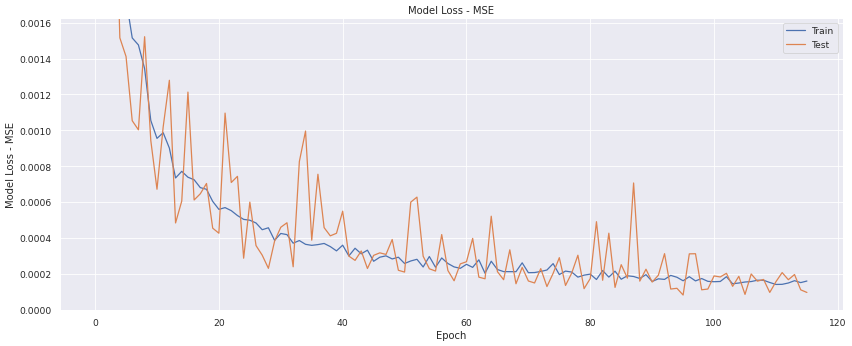

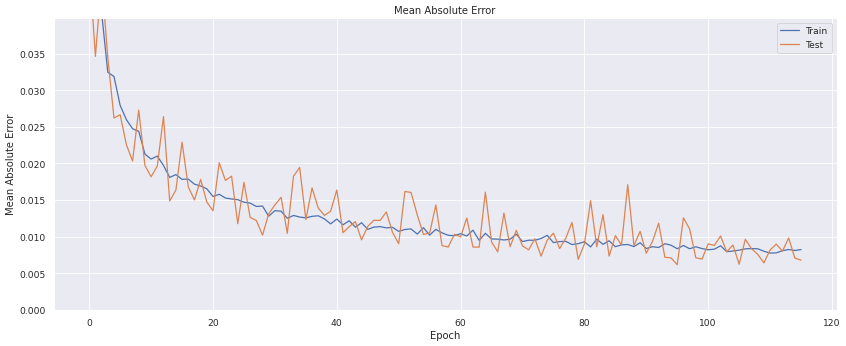

In [47]:
# Plot train vs test loss during training
plot_results(history.history['loss'], history.history['val_loss'], 'Model Loss - MSE')

# Plot train vs test accuracy during training
plot_results(history.history['mae'], history.history['val_mae'], 'Mean Absolute Error')

### Model Performance on Validation Dataset
Performance with model weights as of last epoch

In [48]:
print('Model Evaluation Loss: {:.3f}'.format(model.evaluate(X_valid, y_valid)[0]))

214/214 [==============================] - 0s 2ms/step - loss: 8.2012e-05 - mae: 0.0062 - mse: 8.2012e-05
Model Evaluation Loss: 0.000


Loading the best model weights due to early stopping

In [49]:
model.load_weights('../model/best_model.hdf5')
model.evaluate(X_valid, y_valid)

214/214 [==============================] - 0s 2ms/step - loss: 8.2012e-05 - mae: 0.0062 - mse: 8.2012e-05


[8.201237506000325e-05, 0.006154001224786043, 8.201237506000325e-05]

### Model Prediction on test data
Prediction on unseen data

In [50]:
predict_features = np.array(X_test)
y_predict = targetScaler.inverse_transform(model.predict(predict_features))

In [51]:
y_test['predictVolatility'] = y_predict

Actual and Predicted values comparsion.  Blue dots should lie on the black line.

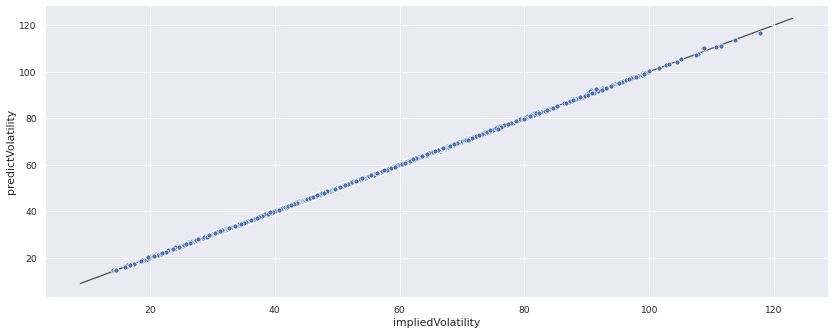

In [52]:
plot_check(y_test, target[0], 'predictVolatility')

Statistics between Actual and Predicted values should be consistent.

In [53]:
y_test.describe()

,impliedVolatility,predictVolatility
count,6835.000000,6835.000000
mean,49.883989,49.904461
std,11.990277,11.987226
min,14.016665,14.461765
25%,41.998380,42.007797
50%,49.286108,49.298428
75%,56.315652,56.307188
max,117.717200,116.706543


RMSE should be low and as close to zero as possible.  The results on test data (unseen data) is good.

In [54]:
from sklearn.metrics import mean_squared_error 
realVals = y_test[target]
predictedVals = y_test['predictVolatility']
rmse = mean_squared_error(realVals, predictedVals, squared = False)
print('RMSE: {:.3f}'.format(rmse))

RMSE: 0.116


## New Out-of-Sample testing
This is a new dataset of option prices extracted from an external source at a different time.  Purpose is to test robustness of a model trained on a particular day still works on data provided on another day.

In [55]:
outofsample = pd.read_csv(DATA_FOLDER + 'out_of_sample.csv')

In [56]:
outofsample['underlyingDiv'] = outofsample['underlyingDiv']/100

In [57]:
%time outofsample['impliedVolatility'] = outofsample.apply(lambda x: calcImpliedVol(x), axis=1)

CPU times: user 15.1 s, sys: 0 ns, total: 15.1 s
Wall time: 15.1 s


In [58]:
outofsample = outofsample[outofsample['last'] > 0]
outofsample.shape

(40735, 22)

In [59]:
print(pd.to_datetime(outofsample.datetimestamp).dt.tz_localize('UTC').dt.tz_convert('US/Eastern').min())
print(pd.to_datetime(outofsample.datetimestamp).dt.tz_localize('UTC').dt.tz_convert('US/Eastern').max())

2020-07-08 16:21:50.954990-04:00
2020-07-08 17:09:23.581974-04:00


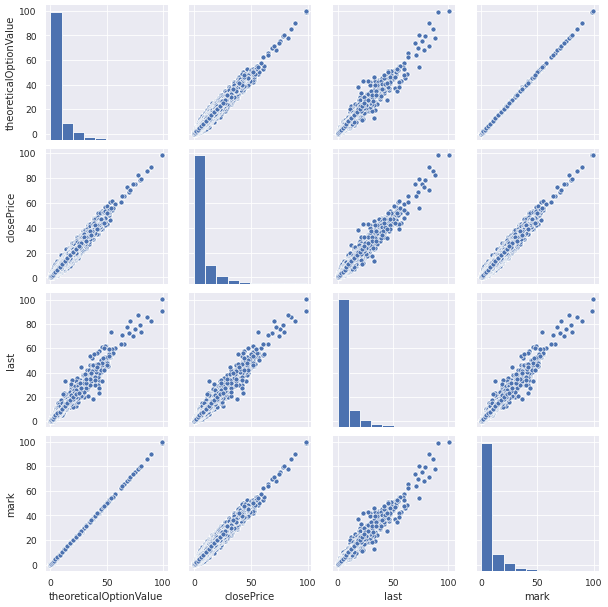

In [60]:
plot_pairs(outofsample, ['theoreticalOptionValue','closePrice','last','mark'])

### Feature Selection

In [61]:
outofsample = outofsample[features + target]
X_outofsample = outofsample[features]
y_outofsample = outofsample[target]

### Feature Transformation

In [62]:
X_outofsample = applyStdScaler(X_outofsample, tonormalise, trainScaler)
X_outofsample = applyOHE(X_outofsample, 'underlyingSymbol', symbol_OHE)
X_outofsample = applyLE(X_outofsample, 'putCall', putCall_LE)

### Model Prediction

In [63]:
predict_features = np.array(X_outofsample)
%time y_predict = targetScaler.inverse_transform(model.predict(predict_features))
y_outofsample['predictVolatility'] = y_predict

CPU times: user 3.83 s, sys: 703 ms, total: 4.53 s
Wall time: 2.08 s


### Model Performance
Good to see that the blue dots are still close to the black line.

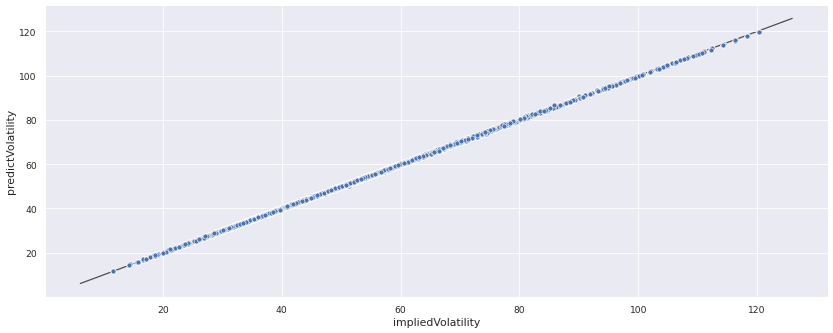

In [64]:
plot_check(y_outofsample, target[0], 'predictVolatility')

In [65]:
y_outofsample.describe()

,impliedVolatility,predictVolatility
count,40735.000000,40735.000000
mean,49.355859,49.384781
std,12.185250,12.175607
min,11.523209,11.554329
25%,41.170938,41.203754
50%,48.603797,48.627876
75%,55.837628,55.842512
max,120.453673,119.857323


In [66]:
from sklearn.metrics import mean_squared_error 
realVals = y_outofsample[target]
predictedVals = y_outofsample['predictVolatility']
rmse = mean_squared_error(realVals, predictedVals, squared = False)
print('RMSE: {:.3f}'.format(rmse))

RMSE: 0.115


In [67]:
y_outofsample

,impliedVolatility,predictVolatility
0,55.210339,55.068115
1,54.432086,54.281960
2,53.666129,53.592678
3,52.912282,52.827488
4,52.170360,52.095524
...,...,...
45525,55.700577,55.766045
45526,58.162938,58.176338
45527,60.624212,60.678741
45528,63.084376,63.248672


## Concluding Notes
1.  It is possible to build a deep learning model to calculate the implied volatility of an option with minimal observable data.
2.  Model accuracy should improve with more layers and nodes but training time will increase.
3.  Model accuracy should improve with more training data.
4.  Model can be updated with new feeds of training data to reflect the most recent market conditions.
5.  Analysis will need a significant large dataset to capture the larger spectrum of prices due the normalisation and scaling to improve the confidence level of the model performance.

# Thank you